In [ ]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, disk
from skimage.measure import label, regionprops

In [5]:
data = tifffile.imread('data/data_reg.tif')
movie = (data - data.min(axis=(1, 2), keepdims=True)) / (np.ptp(data, axis=(1,2), keepdims=True))
movie.shape

(3000, 170, 170)

## Automated ROI Detection  
  
This module introduces a structured approach for identifying neurons automatically in calcium imaging datasets. Manual annotation is useful for small-scale analysis, but for large experiments, automated Region of Interest (ROI) detection is essential. The process will be divided into four stages — enhancing the image, intuition of candidate regions, refining masks, and evaluating results.

### **Preprocessing**  
  
Raw calcium imaging data often contains noise that can obscure the structure of neurons. Before beginning the detection process, it is important to enhance the image so that relevant features are easier to identify. In this section, you will generate projection images from the full movie and apply Gaussian filtering to reduce high-frequency noise. This will help reveal neuron shapes more clearly and improve the reliability of later detection steps.

**Exercise** Create mean projection

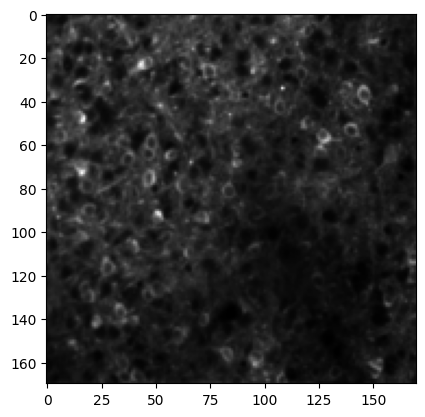

In [6]:
proj = np.mean(movie, axis=0)
plt.imshow(proj, cmap='gray')

**Exercise** Create max projection

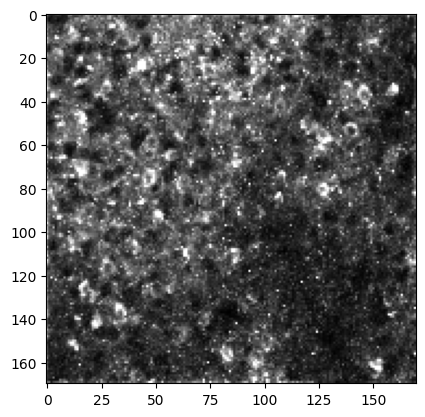

In [7]:
proj = np.max(movie, axis=0)
plt.imshow(proj, cmap='gray')

**Exercise** Create standard deviation projection

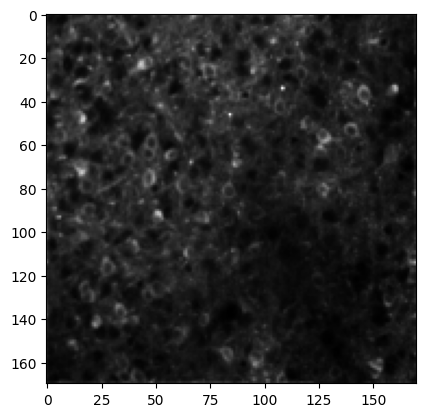

In [8]:
proj = np.std(movie, axis=0)
plt.imshow(proj, cmap='gray')

Gaussian filtering reduces high-frequency noise and enhances the appearance of cell-bodies

**Exercise** Apply gaussian filtering to mean projection image with sigma=1

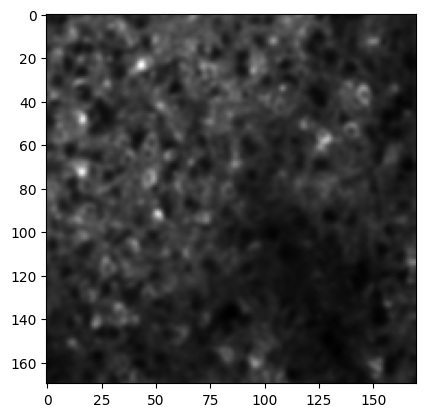

In [9]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=1)
plt.imshow(proj_smooth, cmap='gray')

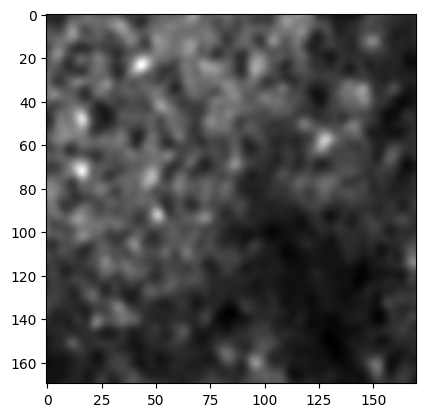

In [10]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=2)
plt.imshow(proj_smooth, cmap='gray')

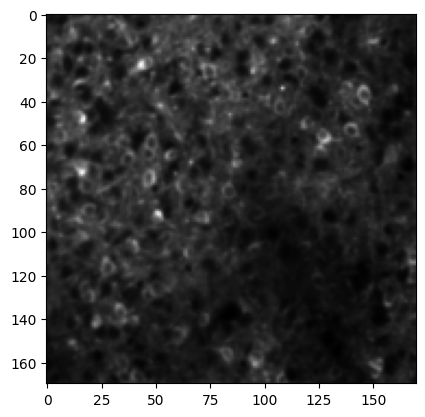

In [11]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)
plt.imshow(proj_smooth, cmap='gray')

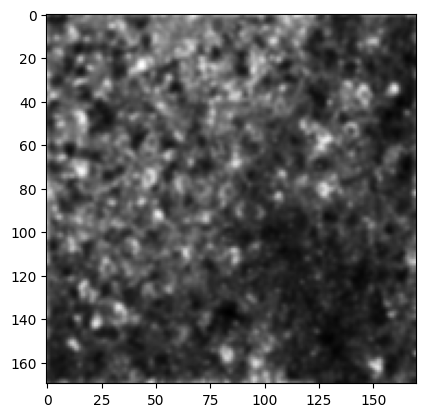

In [12]:
proj = np.max(movie, axis=0)
proj_smooth = gaussian(proj, sigma=1)
plt.imshow(proj_smooth, cmap='gray')

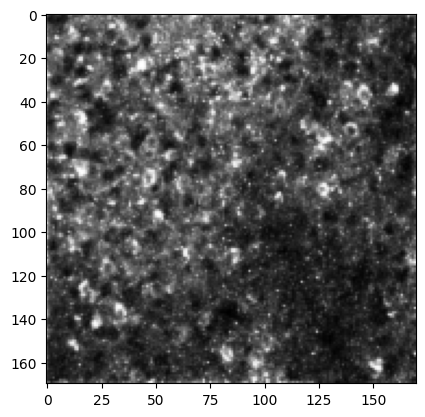

In [13]:
proj = np.max(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)
plt.imshow(proj_smooth, cmap='gray')

Compare raw and smooth image

**Exercise** Compare mean projection with its smoothed version (sigma=0.5)

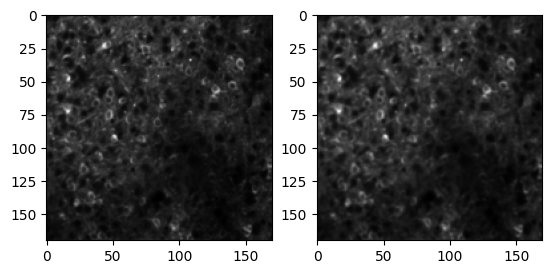

In [15]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)

plt.subplot(121)
plt.imshow(proj, cmap='gray')

plt.subplot(122)
plt.imshow(proj_smooth, cmap='gray')

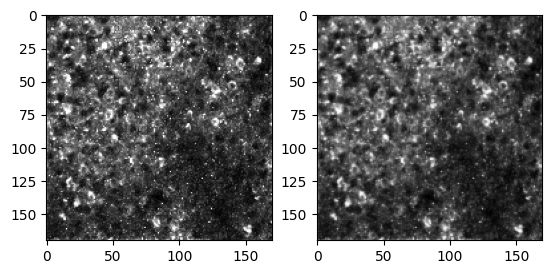

In [18]:
proj = np.max(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)

plt.subplot(121)
plt.imshow(proj, cmap='gray')

plt.subplot(122)
plt.imshow(proj_smooth, cmap='gray')

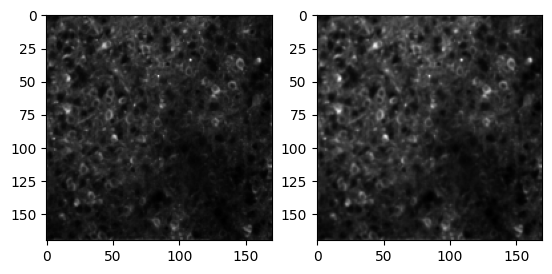

In [20]:
proj = np.std(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)

plt.subplot(121)
plt.imshow(proj, cmap='gray')

plt.subplot(122)
plt.imshow(proj_smooth, cmap='gray')

### **Locating Candidate Neurons to Gain Intuition For Thresholding**  
  
Once the image has been enhanced, the next task is to identify candidate locations that may correspond to neurons. Neurons typically appear as bright, circular features in projection images. In this section, we will use peak detection methods to locate local intensity maxima. This will allow us to see possible locations of neurons.

**Example** Find local peaks.

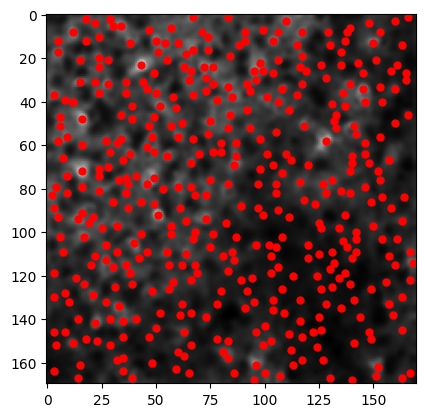

In [147]:
coordinates = peak_local_max(proj_smooth)
plt.imshow(proj_smooth, cmap='gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro', markersize=5)

We can use a parameter `min_distance` to set how far we think the gap should be between two peaks. For example, `min_distance=5` prevents peaks from being closer than 5 pixels. This is useful when neurons are tightly packed.

Change `min_distance` to 1

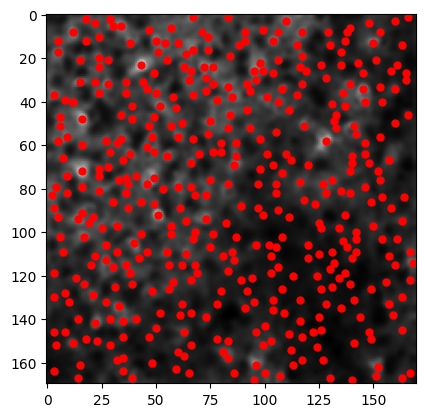

In [41]:
coordinates = peak_local_max(proj_smooth, min_distance=1)
plt.imshow(proj_smooth, cmap='gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro', markersize=5)

Change `min_distance` to 2

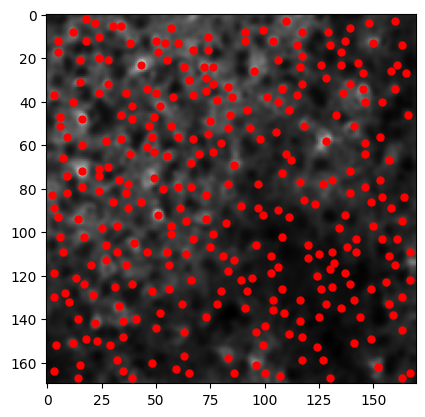

In [42]:
coordinates = peak_local_max(proj_smooth, min_distance=2)
plt.imshow(proj_smooth, cmap='gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro', markersize=5)

Change `min_distance` to 7

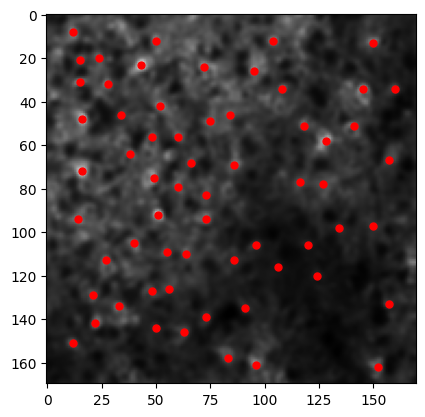

In [50]:
coordinates = peak_local_max(proj_smooth, min_distance=7)
plt.imshow(proj_smooth, cmap='gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro', markersize=5)


### **Segmenting Neuron Shapes: Refining ROIs**  

Candidate peaks provide approximate locations, but we need to define complete neuron shapes for signal extraction. In this section, you will refine ROI boundaries by applying image segmentation techniques. This includes thresholding the smoothed image, applying morphological operations to clean and close the binary mask.

**Example** What is the threshold if we want the components to be brighter than 1% of the pixels?

In [74]:
image = proj_smooth.copy()
thresh = np.percentile(image, 1)
thresh

np.float64(0.08494131425051975)

What is the threshold if we want the components to be brighter than 50% of the pixels?

In [75]:
image = proj_smooth.copy()
thresh = np.percentile(image, 50)
thresh

np.float64(0.14289398487656207)

What is the threshold if we want the components to be brighter than 90% of the pixels?

In [76]:
image = proj_smooth.copy()
thresh = np.percentile(image, 90)
thresh

np.float64(0.2077518784058565)

**Example** Apply binary mask for components brighter than 1% of the pixels.

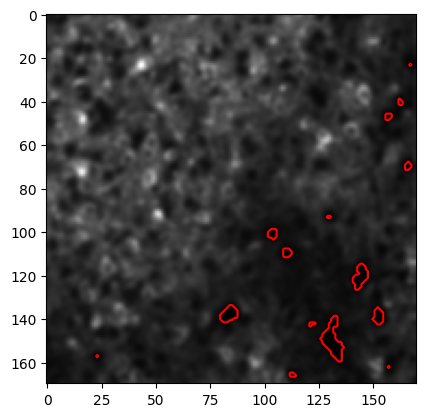

In [85]:
thresh = np.percentile(image, 1)
binary_mask = image > thresh
plt.imshow(image, cmap='gray')
plt.contour(binary_mask, colors='red')

Apply binary mask for components brighter than 50% of the pixels.

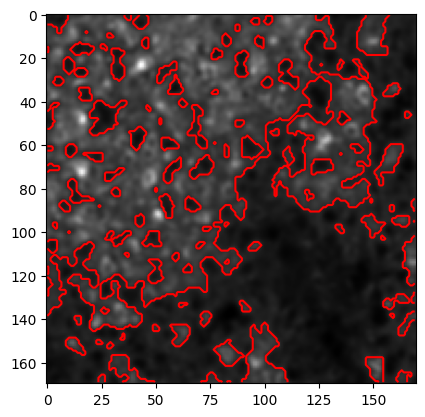

In [86]:
thresh = np.percentile(image, 50)
binary_mask = image > thresh
plt.imshow(image, cmap='gray')
plt.contour(binary_mask, colors='red')

Apply binary mask for components brighter than 90% of the pixels.

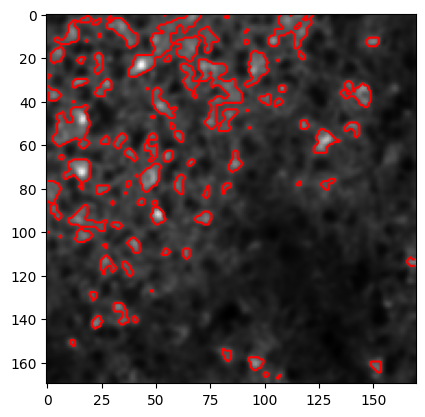

In [102]:
thresh = np.percentile(image, 90)
binary_mask = image > thresh
plt.imshow(image, cmap='gray')
plt.contour(binary_mask, colors='red')

Raw binary masks can be messy. They might include small noise specks, holes inside cells, or ragged edges. Morphological operations are a set of image transformations that improve the shape and quality of binary masks.

We will use two common operations here

- `remove_small_objects`: to get rid of specks and fragments that are too small to be cells.
- `binary_closing`: fills tiny holes and connects small gaps in neuron masks

`remove_small_objects` operation removes small, irrelevant objects from the binary mask that are smaller than specified number of pixels. 

**Example** Remove objects which are smaller than 2 pixels.

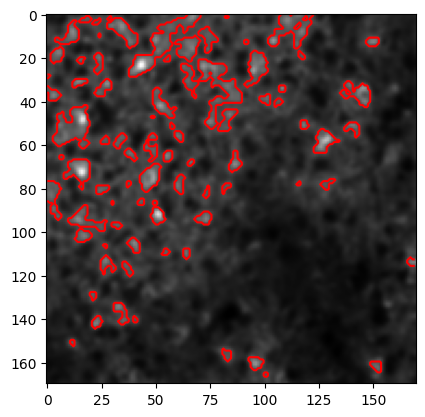

In [104]:
cleaned_mask = remove_small_objects(binary_mask, min_size=2)
plt.imshow(image, cmap='gray')
plt.contour(cleaned_mask, colors='red')

Remove objects which are smaller than 100 pixels.

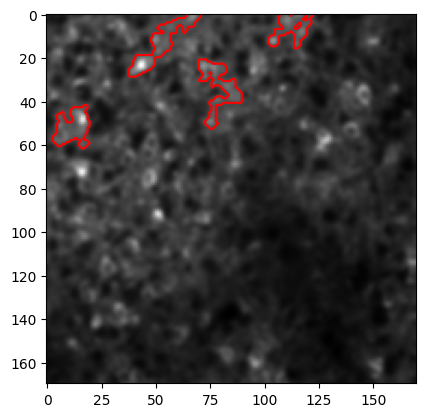

In [108]:
cleaned_mask = remove_small_objects(binary_mask, min_size=100)
plt.imshow(image, cmap='gray')
plt.contour(cleaned_mask, colors='red')

Remove objects which are smaller than 5 pixels.

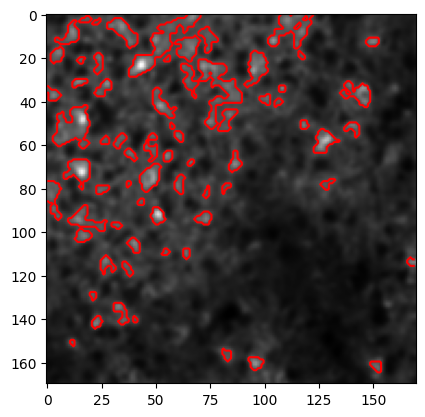

In [109]:
cleaned_mask = remove_small_objects(binary_mask, min_size=5)
plt.imshow(image, cmap='gray')
plt.contour(cleaned_mask, colors='red')

Closing the mask fills small gaps and holes within the segmented regions of the image, improving the shape of the objects of interest. This is done by expanding and then shrinking the regions in a smooth, circular pattern. `disk(2)` here creates a round structuring element with radius 2 pixels, used as a smoothing template.
 
**Example** Close the mask with a footprint of 3 pixels.

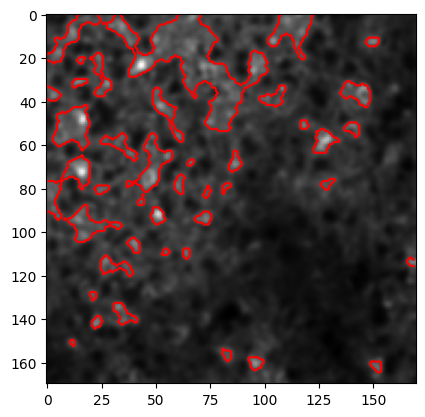

In [126]:
closed_mask = binary_closing(cleaned_mask, footprint=disk(3))
plt.imshow(image, cmap='gray')
plt.contour(closed_mask, colors='red')

Close the mask with a footprint of 10 pixels.

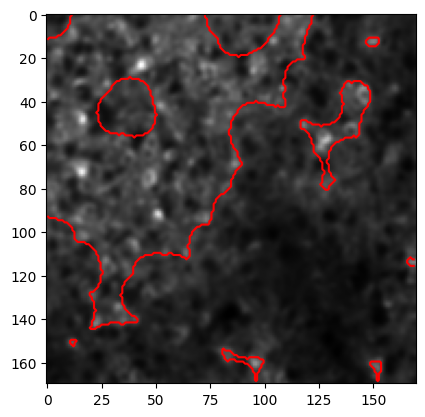

In [124]:
closed_mask = binary_closing(cleaned_mask, footprint=disk(10))
plt.imshow(image, cmap='gray')
plt.contour(closed_mask, colors='red')

Close the mask with a footprint of 0.6 pixels.

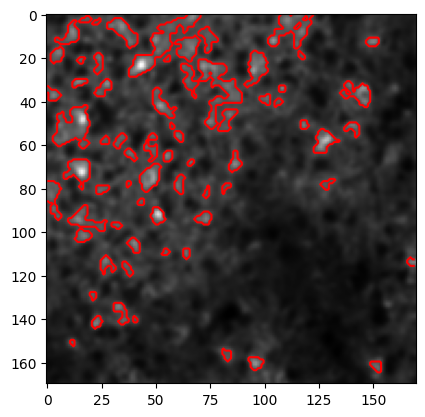

In [136]:
closed_mask = binary_closing(cleaned_mask, footprint=disk(0.6))
plt.imshow(image, cmap='gray')
plt.contour(closed_mask, colors='red')

### Labeling Components and Region Properties

With a cleaned binary mask, we can now label each connected component and extract shape features like size, position, and eccentricity.

Label each component of `closed_mask` and call it `labeled_rois`.

In [137]:
labeled_rois = label(closed_mask)
np.unique(labeled_rois)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
      dtype=int32)

Get region properties of `labeled_rois` and assign it to `regions`.

In [139]:
regions = regionprops(labeled_rois)

**Example** What is the area of first component?

In [140]:
region = regions[1]
region.area

np.float64(171.0)

Where is the centroid of first component?

In [141]:
region.centroid

(np.float64(6.239766081871345), np.float64(112.3625730994152))

What is the perimeter of the first component?

In [142]:
region.perimeter

np.float64(87.59797974644667)

What is the eccentricity of the first component?

In [143]:
region.eccentricity

0.744047303374839

How many pixels are in the first component?

In [146]:
region.num_pixels

np.int64(19)

**Demo**

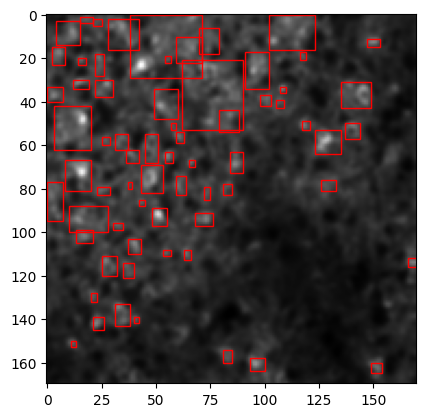

In [144]:
from matplotlib.patches import Rectangle

plt.imshow(image, cmap='gray')
for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
                     edgecolor='red', facecolor='none', linewidth=1)
    plt.gca().add_patch(rect)